In [1]:
import sys
sys.path+= ["../"]
from ResonanceEquationsOfMotions import ResonanceEquations
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
res_eqs = ResonanceEquations(5,2,n_quad_pts=50)

In [3]:
def set_masses_from_mratio_eps(mratio,eps,res_eqs):
    """
    Reset the planet masses of a ResonanceEquations object 
    by setting the planets' mass ratio and the epsilon
    parameter m1*m2/(m1+m2).
    
    Arguments
    ---------
    mratio : float
        Ratio of planet masses m2/m1
    eps : float
        Value of m1*m2 / (m1+m2)
    res_eqs : ResonanceEquationsOfMotions.ResonanceEquations
        Resonance eqautions instance to set masses for. 
    """
    res_eqs.m2 = mratio * res_eqs.m1
    epsOld = (res_eqs.m2 * res_eqs.m1) / (res_eqs.m1 + res_eqs.m2)
    res_eqs.m1 *= (eps / epsOld)
    res_eqs.m2 *= (eps / epsOld)

In [4]:
def R_of_e1cos_e2cos(x,res_eqs,returnInputs=False):
    e1cos,e2cos=x
    e1 = np.abs(e1cos)
    e2 = np.abs(e2cos)
    orbels = np.array((res_eqs.alpha,e1,0,1,e2,0))
    z = res_eqs.orbels_to_dyvars(orbels)
    k = res_eqs.k
    z[0] = np.pi / res_eqs.k + np.arccos(np.sign((-1)**k * e1cos)) 
    z[1] = np.pi / res_eqs.k + np.arccos(np.sign((-1)**k * e2cos))
    if returnInputs:
        return z,res_eqs.Rav(z)
    return res_eqs.Rav(z)

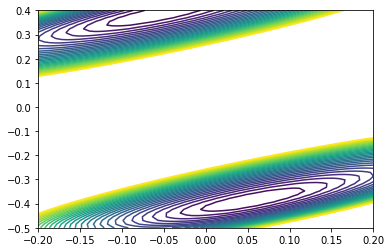

In [5]:
res_eqs.j = 5
res_eqs.k = 2
Ngrid=60
e1range = np.linspace(-0.2,0.2,Ngrid)
e2range = np.linspace(-0.5,0.4,Ngrid)
Z = np.zeros((Ngrid,Ngrid))
els = []
for i,e1cos in enumerate(e1range):
    for j,e2cos in enumerate(e2range):
        Z[j,i]= R_of_e1cos_e2cos((e1cos,e2cos),res_eqs)
    

X,Y = np.meshgrid(e1range,e2range)
plt.contour(X,Y,Z,np.linspace(*np.quantile(Z,(0,0.4)),30))

In [6]:
from scipy.optimize import lsq_linear

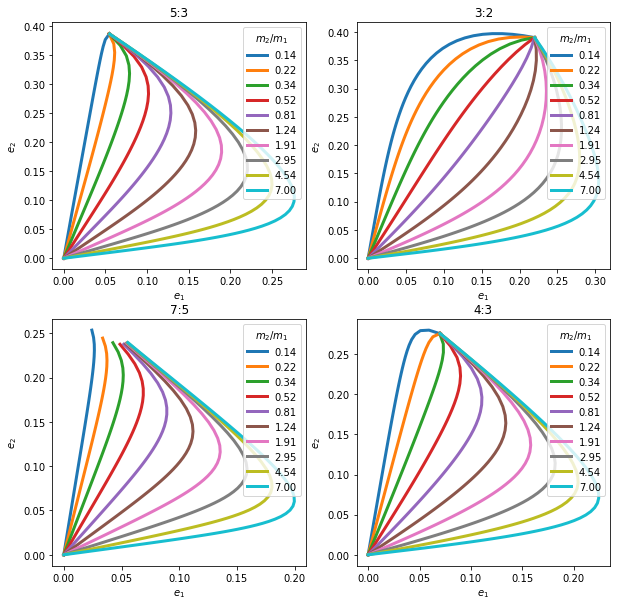

In [7]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
# Maximum number of Newton root-finding steps to take
# and absolute tolerance for root determination.
MAX_ITER = 10
TOL = 1e-9
# Number of points for each ACR track
Npt = 80

# Eccentricities at which to start search for minimum disturbing function value. 
e_mins_init = (0.07,-0.3)

# Planet mass ratio range
planet_mass_ratios = np.logspace(-np.log10(7),np.log10(7),10)
#np.sort(np.append(1/np.linspace(1,5,3)[1:],np.linspace(1,5,3)))

acr_loc_dict = dict()
# Loop over resonances
for axI,jk in enumerate([(5,2),(3,1),(7,2),(4,1)]):
    
    ax = axes[axI]
    res_eqs.j,res_eqs.k = jk
    
    e_mins_init = (0.1,-0.3) 
    
    minroot = minimize(R_of_e1cos_e2cos,x0=e_mins_init,args=(res_eqs))
    acr_loc_dict.update({jk:dict()})      
    # Loop over planet mass ratios 
    for mratio in planet_mass_ratios:

        set_masses_from_mratio_eps(mratio,2e-4,res_eqs)
        
        # For som reason the 7:5 MMR needs some annoying hand-holding to 
        # get the ACR tracks correct. For the 7:5 MMR we'll build tracks 
        # from low AMD to high AMD instead.
        if res_eqs.j==7:            
            # Set the max amd form a rough estimate of the location of (e1*,e2*)
            y = res_eqs.orbels_to_dyvars([res_eqs.alpha,0.04,0.5 *np.pi,1,.24, 1.5 * np.pi])
            amdmax = y[-1]
        else:            
            y,_=R_of_e1cos_e2cos(minroot.x,res_eqs,returnInputs=True)
            amdmax = y[-1]
            
        # set the starting point at low AMD
        y = res_eqs.orbels_to_dyvars([res_eqs.alpha,0.01,0,1,.01, 0])
        amdmin = y[-1]
        
        if res_eqs.k==2:
            y[0] = 0.5*np.pi
            y[1] = 1.5 * np.pi
        else:
            y[0] = 0
            y[1] = np.pi            
        e1,e2 = np.zeros((2,Npt))    
        amdrange = np.logspace(np.log10(amdmin),np.log10(amdmax),Npt)
        y = np.array(y)
        lb = np.array([-np.pi,-np.pi, -1* y[2], -1 * y[3]])
        ub = np.array([np.pi,np.pi,np.inf,np.inf])
        
        # Loop over AMD values
        for i,amd0 in enumerate(amdrange):
            
            y[-1]=amd0
            f = res_eqs.H_flow(y)[:-1]
            J = res_eqs.H_flow_jac(y)[:-1,:-1]
            it=0
            
            # Newton method iteration
            while np.linalg.norm(f)>TOL and it < MAX_ITER:
                # Note-- using constrained least-squares
                # to avoid setting actions to negative 
                # values.
                lb[2:] =  -1* y[2:-1]
                dy = lsq_linear(J,-f,bounds=(lb,ub)).x
                y[:-1] = y[:-1] + dy
                f = res_eqs.H_flow(y)[:-1]
                J = res_eqs.H_flow_jac(y)[:-1,:-1]
                it+=1
            _,e1[i],_,_,e2[i],_ = res_eqs.dyvars_to_orbels(y) # 
            if it == MAX_ITER:
                print("Warning, max. iter. hit for (amd,gamma)=({:.2f},{:.2f})".format(amd0,mratio))
                
        ax.plot(np.append([0],e1),np.append([0],e2),label="{:.2f}".format(mratio),lw=3)
        
        acr_loc_dict[jk].update({mratio:[np.append([0],e1),np.append([0],e2)]})
        
    ax.set_xlabel(r"$e_1$")
    ax.set_ylabel(r"$e_2$")
    ax.set_title(r"{:d}:{:d}".format(res_eqs.j,res_eqs.j-res_eqs.k))
    ax.legend(title=r"$m_2/m_1$")


Export computed ACR tracks to a binary file.

In [211]:
import pickle

with open("./ACR_locations_data.pkl","wb") as fi:
    pickle.dump(acr_loc_dict,fi)

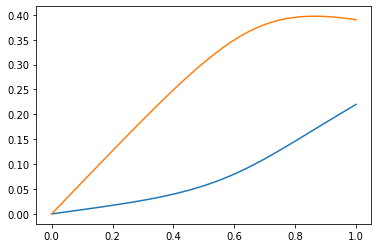

In [38]:
mratio = 0.14285714285714285
e1data,e2data = acr_loc_dict[3,1][mratio]

beta1,beta2=1/(1+mratio),mratio/(mratio+1)

scaled_amd = (beta1 * np.sqrt(res_eqs.alpha) * e1data**2 + beta2 * e2data**2)
scaled_amd /= np.max(scaled_amd)
rt_scaled_amd = np.sqrt(scaled_amd)
plt.plot(rt_scaled_amd,e1data,'-')
plt.plot(rt_scaled_amd,e2data)